In [1]:
import snntorch as snn
import torch

#   training parameters
batch_size = 128
data_path = '/tmp/data/mnist'
num_classes = 10 #  MNIST has 10 output neurons --> 10 classes
#   torch variables
dtype = torch.float

In [2]:
#   We need to download the dataset, if it is not already downloaded
from torchvision import datasets, transforms

cfg = [transforms.Resize((28,28)), transforms.Grayscale(), 
       transforms.ToTensor(), transforms.Normalize((0,),(1,))]
transform = transforms.Compose(cfg)

mnist_train = datasets.MNIST(data_path,train=True,download=True,transform=transform)

In [3]:
from snntorch import utils
subset = 10
mnist_train = utils.data_subset(mnist_train,subset) #   reduce by a factor of 10
print(f"The size of mnist_train is {len(mnist_train)}")

The size of mnist_train is 6000


In [4]:
#   Create dataloaders
#   The dataset object is loaded into memory, the dataloader serves it up in batches.
#   Dataloaders in PyTorch are a handy interface for passing data into a network. The segment
#   the dataset into batches, specified from the mini-batches parameter
from torch.utils.data import DataLoader
train_loader = DataLoader(mnist_train, batch_size = batch_size, shuffle = True)

In [5]:
#   Spike Encoding
#   SNNs are made to exploit time-varying data. And yet, MNIST is not a time-varying dataset.
#   There are two options for using MNIST with an SNN

#   1.  Repeatedly pass the same training sample X from the image, to the network at each time step.
#       This is like converting MNIST into a static, unchanging video! Each element of X can take a 
#       high precision valie normalized between 0 and 1. 
#   2.  Convert the input into a spike train of sequence length equal to number of steps. 
#       Each feature/pixel takes on a discrete value X(i,j) in {0,1}. In this case, MNIST
#       is converted into a time-varying sequence of spikes that features a relation to the 
#       original image.
#   The first method is quite simple, and does not fully exploit the temporal dynamics of SNNs.
#   Data encoding from (2) is going to be explored.
#   The module spikegen contains a series of functions that simplify the conversion of data into
#   spikes. There are currently three options available for spike encoding in snntorch.
#       1. Rate Coding: uses input features to determine spiking frequency
#       2. Latency Coding: uses input features to determine spiking timing
#       3. Delta Modulation: uses the temporal change of input features to generate spikes
#   Rate Coding of MNIST:   feed the normalized feature to an encoder. The encoder uses the value as
#                           a spiking probability (Bernoulli).
#   Example: create a vector filled with the value 0.5 and encode it using Rate Coding
num_steps = 10
raw_vector = torch.ones(num_steps)*0.5
rate_coded_vector = torch.bernoulli(raw_vector)
print(f"Converted vector: {rate_coded_vector}")
print(f"The output is spiking {rate_coded_vector.sum()*100/len(rate_coded_vector)}")

Converted vector: tensor([0., 1., 1., 0., 0., 0., 0., 0., 1., 0.])
The output is spiking 30.0


In [6]:
#   If we now increase the length of the vector
num_steps = 100
raw_vector = torch.ones(num_steps)*0.5
rate_coded_vector = torch.bernoulli(raw_vector)
print(f"The output is spiking {rate_coded_vector.sum()*100/len(rate_coded_vector)}")
#   The output will always be around 50%, the probability of the vector

The output is spiking 46.0


In [7]:
#   For an MNIST image, the probability of spiking corresponds to the pixel value. A white
#   pixel corresponds to a 100% probability of spiking, and a black pixel will never generate
#   spike. In similar way, spikegen.rate can be used to generate a rate-coded sample of data.
#   As each sample of MNIST is just an image, we can use num_steps to repeat it across time.
from snntorch import spikegen
#   Iterate through minibatches
data = iter(train_loader)
data_it, targets_it = next(data)
#   Spiking data
spike_data = spikegen.rate(data_it, num_steps = num_steps)

#   If the input falls outside of [0, 1], this no longer represents a probability.
#   Such cases are automatically clipped to ensure the feature represents a probability
#   The structure of the input data is: [numsteps x batch_size x input dimensiosn]
print(spike_data.size())

torch.Size([100, 128, 1, 28, 28])


In [8]:
#   Visualizing
from matplotlib import pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML
#   To plot one sample of data, index into a single sample from the batch (B) dimension of 
#   spike data.
spike_data_sample = spike_data[:,0,0]
print(spike_data_sample.size())

torch.Size([100, 28, 28])


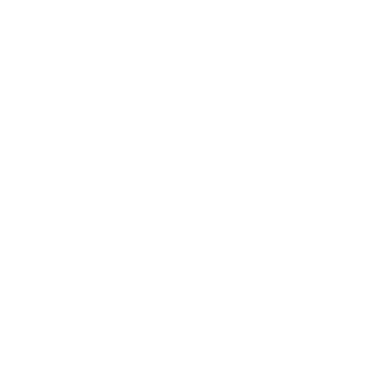

In [10]:
#   spikeplot.animator makes it simple to animate 2-D data. 
fig,ax = plt.subplots()
anim = splt.animator(spike_data_sample,fig,ax)
plt.rcParams['animation.ffmpeg_path'] = 'C:\\ffmpeg-8.0-full_build\\bin\\ffmpeg.exe'
HTML(anim.to_html5_video())
anim.save("spike_mnist_test.mp4")

In [11]:
print(f"The corresponding target is: {targets_it[0]}")

The corresponding target is: 9


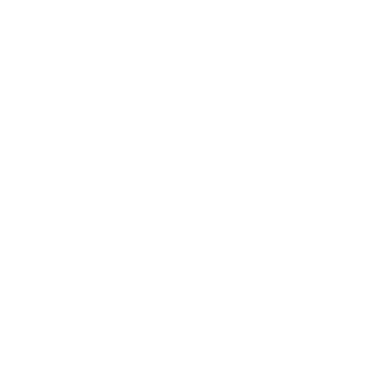

In [12]:
#   We will recreate the video, but with lower spiking frequency
spike_data = spikegen.rate(data_it,num_steps=num_steps,gain=0.25)
spike_data_sample2 = spike_data[:,0,0]
fig,ax = plt.subplots()
anim = splt.animator(spike_data_sample2,fig,ax)
HTML(anim.to_html5_video())

In [13]:
anim.save("spike_mnist_test2.mp4")

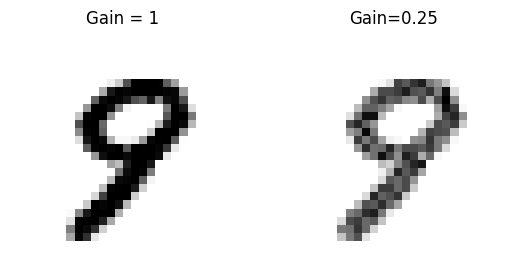

In [14]:
#   We can now average the spikes out over time and reconstruct the input images
plt.figure(facecolor="w")
plt.subplot(1,2,1)
plt.imshow(spike_data_sample.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 1')

plt.subplot(1,2,2)
plt.imshow(spike_data_sample2.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain=0.25')

plt.show()

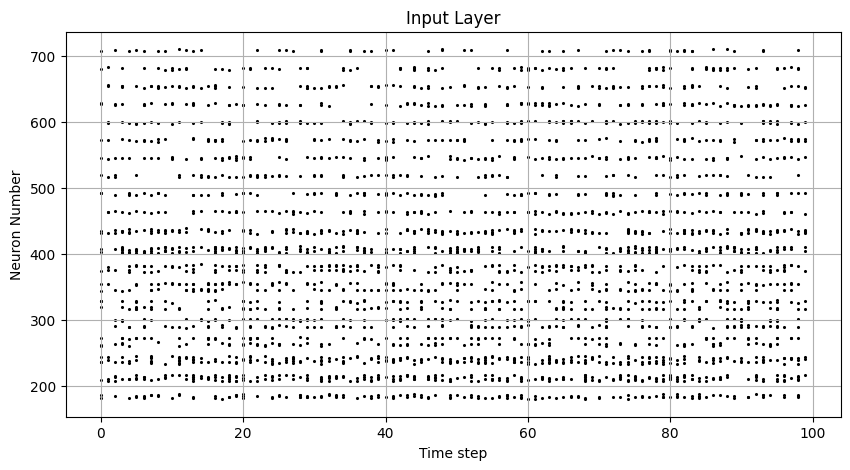

In [23]:
#   raster plot: visualization of the timing of multiple discrete events, most componly neural
#   spikes. It is presented on a trial-by-trial basis, with each row representing a single
#   trial and dots or lines indicating the time of an event. 
#   This graphical method allows for the visual inspection of patterns and variability in the
#   responses of individual neurons or multiple neurons over time, often used in neuroscience
#   to analyze neural activity.
#   From wikipedia: a temporal raster plot is a graphic representation of occurences in a 
#   certain temporal relation. Temporal raster plots are also sometimes referred to as carpet
#   plots. Temporal raster plots make it easy to show time-based relations within large sets
#   of time-interval data and often make it easy to recognize local maxima and minima.
#   Assuming that the chosen time division is related to the events, it is also easy to
#   recognize global and local patterns, such as recurrent events.

#   Reshape the data
spike_data_sample2 = spike_data_sample2.reshape((num_steps,-1))
#   raster plot
fig = plt.figure(facecolor="w",figsize=(10,5))
ax = fig.add_subplot(111)
splt.raster(spike_data_sample2,ax,s=1.5,c='black')

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.grid('on')
plt.show()

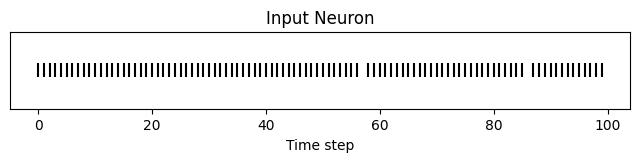

In [20]:
#   Now we will index into a single neuron. Depending on the input data, you may need to try
#   a few different neurons between 0 & 784 before finding one that spikes.
idx = 402
fig = plt.figure(facecolor="w", figsize=(8,1))
ax = fig.add_subplot(111)

splt.raster(spike_data_sample.reshape(num_steps,-1)[:,idx].unsqueeze(1), ax, s=100,c="black",
            marker="|")
plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.show()

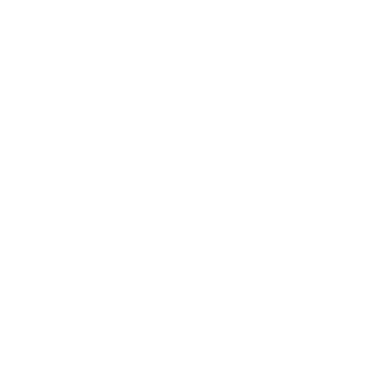

In [24]:
#   Random spike generation
spike_prob = torch.rand((num_steps,28,28),dtype=dtype)*0.5
spike_rand = spikegen.rate_conv(spike_prob)
fig,ax = plt.subplots()
anim = splt.animator(spike_rand,fig,ax)
HTML(anim.to_html5_video())